In [ ]:
# !pip install opencv-python

In [10]:
# !pip install segmentation-models

In [ ]:
# !pip install tensorflow

In [1]:
# import sagemaker
# from sagemaker.tensorflow import TensorFlow as tf

!nvidia-smi

Wed Apr  5 17:27:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| 50%   29C    P8    10W / 200W |    319MiB /  8192MiB |     21%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import os
import psutil

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

# Obtener información sobre la(s) GPU(s) disponible(s)
gpus = tf.config.list_physical_devices('GPU')
print('Número de GPU(s) disponibles:', len(gpus))
for gpu in gpus:
    print('Nombre:', gpu.name)
    print('Tipo:', gpu.device_type)
    # print('Memoria disponible:', gpu.memory_limit)

# Obtenemos la información sobre la cantidad total de CPU y memoria
cpu_count = os.cpu_count()
total_memory = psutil.virtual_memory().total / (1024 ** 3)  # Convertimos a gigabytes

# Imprimimos los resultados
print(f"Cantidad de CPU: {cpu_count}")
print(f"Total de memoria: {total_memory:.2f} GB")

2023-04-05 17:28:18.172899: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 17:28:18.415569: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-05 17:28:19.105188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-05 17:28:19.105607: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Número de GPU(s) disponibles: 1
Nombre: /physical_device:GPU:0
Tipo: GPU
Cantidad de CPU: 4
Total de memoria: 15.59 GB


2023-04-05 17:28:23.720569: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-05 17:28:23.721055: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-05 17:28:23.721427: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-05 17:28:23.721724: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7084 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1
2023-04-05 17:28:23.747459: I tensorflow/stream_executor/cuda/cuda_gpu_executo

In [3]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import cv2
from tensorflow import keras
import segmentation_models as sm
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from simple_multi_unet_model import multi_unet_model, jacard_coef
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

Segmentation Models: using `tf.keras` framework.


In [13]:
sm.set_framework('tf.keras')
sm.framework()
print(tf.__version__)
!pwd

2.7.0
/home/diego/kisui_nav_ai-main/u-net-tensoflow


In [14]:
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format.
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape, dtype=np.uint8)
    label_seg[np.all(label == BACKGROUND, axis=-1)] = 0
    label_seg[np.all(label == Grass, axis=-1)] = 1
    label_seg[np.all(label == Pavement, axis=-1)] = 2
    label_seg[np.all(label == Traversable, axis=-1)] = 3
    label_seg[np.all(label == Branches, axis=-1)] = 4
    label_seg[np.all(label == Person, axis=-1)] = 5
    label_seg[np.all(label == Vehicle, axis=-1)] = 6
    label_seg[np.all(label == Robot, axis=-1)] = 7
    label_seg[np.all(label == Tree, axis=-1)] = 8
    label_seg[np.all(label == Dynamic, axis=-1)] = 9

    label_seg = label_seg[:, :, 0]  # Just take the first channel, no need for all 3 channels

    return label_seg

In [15]:
def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

In [16]:
scaler = MinMaxScaler()
root_directory = '/home/diego/kisui_nav_ai-main/u-net-tensoflow/Dataset/'
# patch_size = 512

In [17]:
image_dataset = []
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    print(dirname)
    if dirname == 'images_prepped_train':
        images = os.listdir(path)
        for image_name in images:
            print(image_name)
            if image_name.endswith(".png"):
                image = cv2.imread(path + "/" + image_name, 1)
                # image = Image.open(path + "/" + image_name)
                image = Image.fromarray(image)
                image = image.resize((1280, 720)) #width 1280 Height 720
                image = np.array(image)
                image = scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)
                # image = image[0] # Drop the extra unnecessary dimension
                single_patch_img = image
                image_dataset.append(single_patch_img)



annotations_prepped_train
images_prepped_train
train_181.png
train_220.png
train_96.png
train_21.png
train_179.png
train_67.png
train_160.png
train_20.png
train_106.png
train_04.png
train_109.png
train_19.png
train_35.png
train_50.png
train_65.png
train_195.png
train_30.png
train_93.png
train_64.png
train_157.png
train_150.png
train_103.png
train_73.png
train_16.png
train_219.png
train_177.png
train_200.png
train_68.png
train_186.png
train_127.png
train_155.png
train_196.png
train_120.png
train_85.png
train_162.png
train_45.png
train_34.png
train_55.png
train_205.png
train_143.png
train_10.png
train_168.png
train_121.png
train_07.png
train_138.png
train_83.png
train_130.png
train_116.png
train_184.png
train_44.png
train_172.png
train_84.png
train_206.png
train_222.png
train_189.png
train_158.png
train_43.png
train_144.png
train_41.png
train_15.png
train_75.png
train_02.png
train_199.png
train_14.png
train_112.png
train_82.png
train_167.png
train_91.png
train_53.png
train_128.png
train

In [18]:
mask_dataset = []

for path, subdirs, files in os.walk(root_directory):
    # print(path)
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'annotations_prepped_train':  # Find all 'images' directories
        masks = os.listdir(path)  # List of all image names in this subdirectory
        for mask_name in masks:
            print(mask_name)
            if mask_name.endswith(".png"):
                mask = cv2.imread(path + "/" + mask_name,1)  # Read each image as Grey (or color but remember to map
                # each color to an integer)
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
                mask = Image.fromarray(mask)
                mask = mask.resize((1280, 720))  #width 1280 Height 720
                mask = np.array(mask)
                # mask = mask[0] # Drop the extra unnecessary dimension
                single_patch_mask = mask
                mask_dataset.append(single_patch_mask)

train_181.png
train_220.png
train_96.png
train_21.png
train_179.png
train_67.png
train_160.png
train_20.png
train_106.png
train_04.png
train_109.png
train_19.png
train_35.png
train_50.png
train_65.png
train_195.png
train_30.png
train_93.png
train_64.png
train_157.png
train_150.png
train_103.png
train_73.png
train_16.png
train_219.png
train_177.png
train_200.png
train_68.png
train_186.png
train_127.png
train_155.png
train_196.png
train_120.png
train_85.png
train_162.png
train_45.png
train_34.png
train_55.png
train_205.png
train_143.png
train_10.png
train_168.png
train_121.png
train_07.png
train_138.png
train_83.png
train_130.png
train_116.png
train_184.png
train_44.png
train_172.png
train_84.png
train_206.png
train_222.png
train_189.png
train_158.png
train_43.png
train_144.png
train_41.png
train_15.png
train_75.png
train_02.png
train_199.png
train_14.png
train_112.png
train_82.png
train_167.png
train_91.png
train_53.png
train_128.png
train_108.png
train_135.png
train_208.png
train_193.p

In [19]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

print(image_dataset.shape)
print(mask_dataset.shape)

(233, 720, 1280, 3)
(233, 720, 1280, 3)


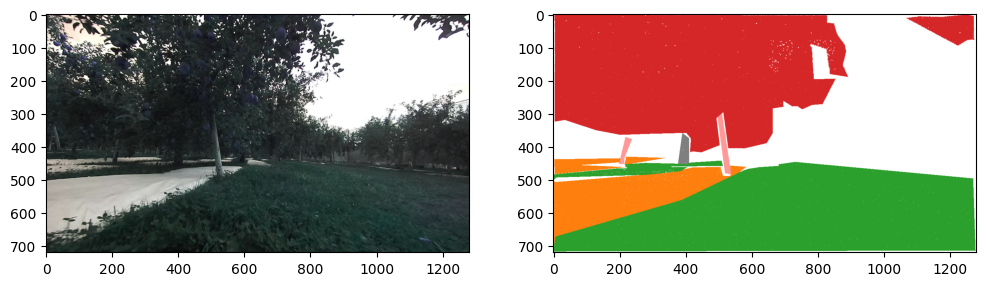

In [20]:
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (720, 1280, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (720, 1280, 3)))
plt.show()

In [21]:
# Convert HEX to RGB array

BACKGROUND = '#ffffff'.lstrip('#')
BACKGROUND = np.array(tuple(int(BACKGROUND[i:i + 2], 16) for i in (0, 2, 4)))  # 60, 16, 152

Grass = '#2ca02c'.lstrip('#')
Grass = np.array(tuple(int(Grass[i:i + 2], 16) for i in (0, 2, 4)))  # 132, 41, 246

Pavement = '#1f77b4'.lstrip('#')
Pavement = np.array(tuple(int(Pavement[i:i + 2], 16) for i in (0, 2, 4)))  # 110, 193, 228

Traversable = 'ff7f0e'.lstrip('#')
Traversable = np.array(tuple(int(Traversable[i:i + 2], 16) for i in (0, 2, 4)))  # 254, 221, 58

Branches = 'd62728'.lstrip('#')
Branches = np.array(tuple(int(Branches[i:i + 2], 16) for i in (0, 2, 4)))  # 226, 169, 41

Person = '#9467bd'.lstrip('#')
Person = np.array(tuple(int(Person[i:i + 2], 16) for i in (0, 2, 4)))  # 155, 155, 155

Vehicle = '#8c564b'.lstrip('#')
Vehicle = np.array(tuple(int(Vehicle[i:i + 2], 16) for i in (0, 2, 4)))  # 155, 155, 155

Robot = '#e377c2'.lstrip('#')
Robot = np.array(tuple(int(Robot[i:i + 2], 16) for i in (0, 2, 4)))  # 155, 155, 155

Tree = '#7f7f7f'.lstrip('#')
Tree = np.array(tuple(int(Tree[i:i + 2], 16) for i in (0, 2, 4)))  # 155, 155, 155

Dynamic = '#bcbd22'.lstrip('#')
Dynamic = np.array(tuple(int(Dynamic[i:i + 2], 16) for i in (0, 2, 4)))  # 155, 155, 155

label = single_patch_mask


In [22]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [23]:
print("label shape", label.shape)
print("labels shape", labels.shape)
print("Unique labels in label dataset are: ", np.unique(labels))

label shape (720, 1280)
labels shape (233, 720, 1280, 1)
Unique labels in label dataset are:  [0 1 2 3 4 5 6 7 8 9]


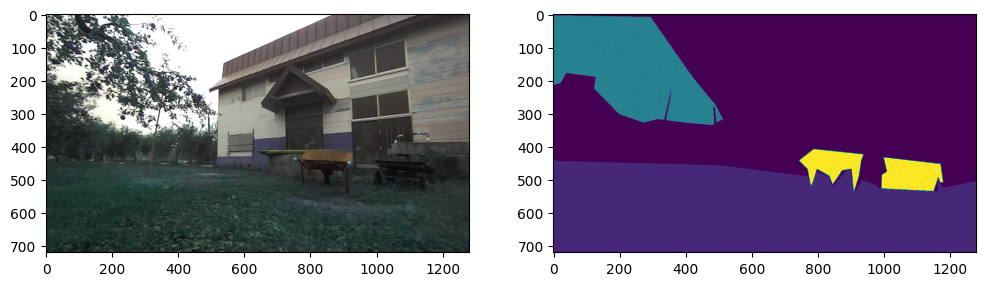

In [24]:
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:, :, 0])
plt.show()

In [ ]:
n_classes = len(np.unique(labels))

labels_cat = to_categorical(labels, num_classes=n_classes)

print(n_classes)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size=0.20, random_state=42)
#print(labels_cat.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(186, 720, 1280, 3)
(47, 720, 1280, 3)
(186, 720, 1280, 10)
(47, 720, 1280, 10)


In [1]:
# Get CPU usage
cpu_percent = psutil.cpu_percent()

# Get memory usage
mem = psutil.virtual_memory()
mem_percent = mem.percent

# Print CPU and memory usage
print(f"CPU Usage: {cpu_percent}%")
print(f"Memory Usage: {mem_percent}%")

NameError: name 'psutil' is not defined

In [ ]:
weights = compute_class_weight(class_weight="balanced", classes=np.unique(np.ravel(labels, order='C')), y=np.ravel(labels, order='C'))
cpu_percent = psutil.cpu_percent()

# Get memory usage
mem = psutil.virtual_memory()
mem_percent = mem.percent

# Print CPU and memory usage
print(f"CPU Usage: {cpu_percent}%")
print(f"Memory Usage: {mem_percent}%")

In [ ]:
print(weights)

In [ ]:
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [ ]:
print(X_train.shape[1])
print(X_train.shape[2])
print(X_train.shape[3])

In [ ]:
def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

In [ ]:
metrics = ['accuracy', jacard_coef]

In [ ]:
model = get_model()

In [ ]:
# model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()

In [ ]:
history1 = model.fit(X_train, y_train,
                     batch_size=8,
                     verbose=1,
                     epochs=100,
                     validation_data=(X_test, y_test),
                     shuffle=False)


In [ ]:
model.save('models/final_model.hdf5')

In [ ]:
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()